In [ ]:
!pip install pytorch-forecasting
!pip install pytorch-lightning

TimeSeries Forecasting

In [3]:
import pandas as pd
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss


# 1. Prepare EKS Data (Requires a numeric 'time_idx' and a categorical 'group_id')
df = pd.read_csv('/content/sample_data/eks_training_data.csv', parse_dates=['DateTime'])
df['time_idx'] = ((df['DateTime'] - df['DateTime'].min()).dt.total_seconds() // 3600).astype(int)
df['group'] = "cluster_1" # Required even for single-series

# 2. Define the Dataset
max_prediction_length = 6
max_encoder_length = 24

training = TimeSeriesDataSet(
    df,
    time_idx="time_idx",
    target="CPU_Usage",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["CPU_Usage", "Disk_Usage"],
    time_varying_known_reals=["time_idx"],
    target_normalizer=GroupNormalizer(groups=["group"])
)

# 3. Initialize and Train
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=4,
    dropout=0.1,
    loss=QuantileLoss() # Provides p10, p50, p90 ranges
)

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:213: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:213: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [4]:
df_test=pd.read_csv('/content/sample_data/test_data.csv', parse_dates=['DateTime'])

def run_predictions(df_test, steps=24):
    """
    Placeholder for your TFT model.predict() logic.
    This simulates the P10, P50, and P90 outputs of a Temporal Fusion Transformer.
    """
    last_date = df_test['DateTime'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=steps, freq='H')

    # Simulating TFT output structure
    base = df['CPU_Usage'].iloc[-1]
    noise = np.random.normal(0, 5, steps).cumsum()
    p50 = base + noise
    p10 = p50 - (np.random.rand(steps) * 10 + 5)
    p90 = p50 + (np.random.rand(steps) * 15 + 10)

    return pd.DataFrame({'DateTime': future_dates, 'p10': p10, 'p50': p50, 'p90': p90})

In [12]:
def run_predictions(df_test, metric_col, steps=24):
    last_date = df_test['DateTime'].max()

    future_dates = pd.date_range(
        start=last_date + pd.Timedelta(hours=1),
        periods=steps,
        freq='H'
    )

    base = pd.to_numeric(df_test[metric_col], errors='coerce').dropna().iloc[-1]

    noise = np.random.normal(0, 5, steps).cumsum()

    p50 = base + noise
    p10 = p50 - (np.random.rand(steps) * 10 + 5)
    p90 = p50 + (np.random.rand(steps) * 15 + 10)

    return pd.DataFrame({
        'DateTime': future_dates,
        'p10': p10,
        'p50': p50,
        'p90': p90
    })


In [13]:
cpu_pred   = run_predictions(df_test, 'CPU_Usage', steps=24)
disk_pred  = run_predictions(df_test, 'Disk_Usage', steps=24)
nodes_pred = run_predictions(df_test, 'Number_of_Nodes', steps=24)


/tmp/ipython-input-3444714473.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(


In [14]:
pred_df = pd.DataFrame({
    'DateTime': cpu_pred['DateTime'],

    'CPU_p10': cpu_pred['p10'],
    'CPU_p50': cpu_pred['p50'],
    'CPU_p90': cpu_pred['p90'],

    'Disk_p10': disk_pred['p10'],
    'Disk_p50': disk_pred['p50'],
    'Disk_p90': disk_pred['p90'],

    'Nodes_p10': nodes_pred['p10'],
    'Nodes_p50': nodes_pred['p50'],
    'Nodes_p90': nodes_pred['p90'],
})


In [ ]:
!pip install onnx
!pip install onnxscript

Rule-based Anomaly Detection


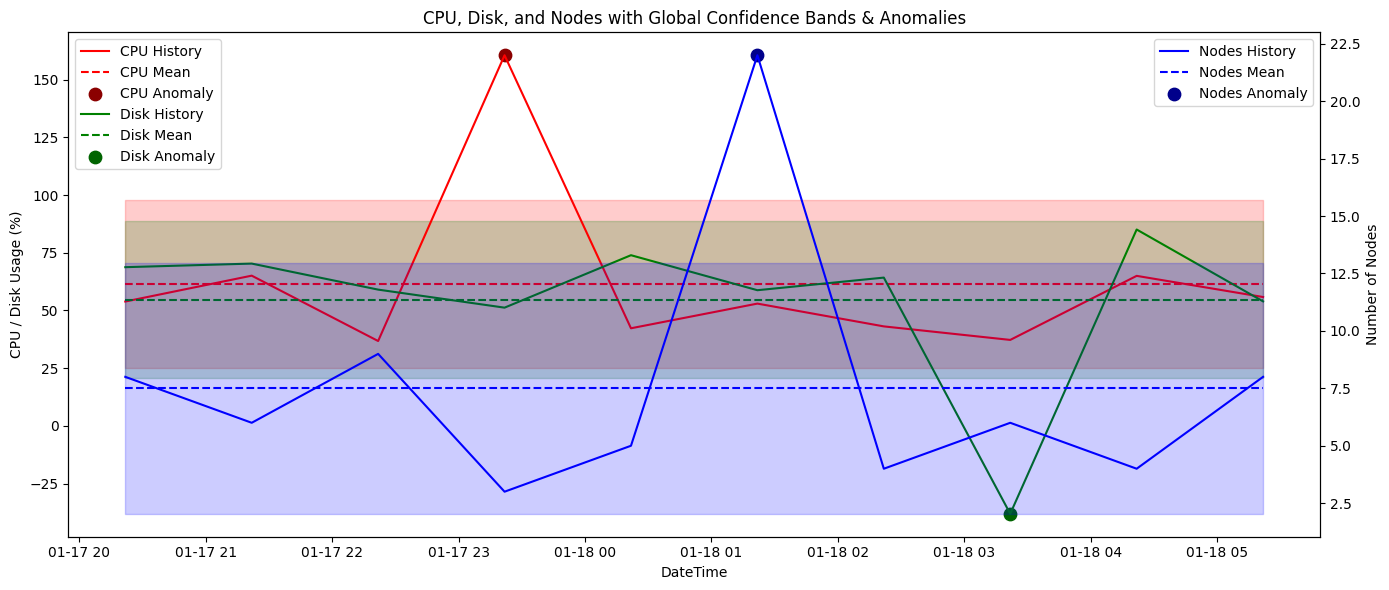

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Inject visible anomalies ---
df_test.loc[3, 'CPU_Usage'] += 25
df_test.loc[7, 'Disk_Usage'] -= 25
df_test.loc[5, 'Number_of_Nodes'] += 4

# --- Global statistics ---
cpu_mean, cpu_std = df_test['CPU_Usage'].mean(), df_test['CPU_Usage'].std()
disk_mean, disk_std = df_test['Disk_Usage'].mean(), df_test['Disk_Usage'].std()
nodes_mean, nodes_std = df_test['Number_of_Nodes'].mean(), df_test['Number_of_Nodes'].std()

# --- Confidence bands dataframe ---
pred_df = pd.DataFrame({
    'DateTime': df_test['DateTime'],

    'CPU_p10': cpu_mean - cpu_std,
    'CPU_p50': cpu_mean,
    'CPU_p90': cpu_mean + cpu_std,

    'Disk_p10': disk_mean - disk_std,
    'Disk_p50': disk_mean,
    'Disk_p90': disk_mean + disk_std,

    'Nodes_p10': nodes_mean - nodes_std,
    'Nodes_p50': nodes_mean,
    'Nodes_p90': nodes_mean + nodes_std
})

# --- Anomaly detection ---
df_test['anomaly_cpu'] = (
    (df_test['CPU_Usage'] < pred_df['CPU_p10']) |
    (df_test['CPU_Usage'] > pred_df['CPU_p90'])
)

df_test['anomaly_disk'] = (
    (df_test['Disk_Usage'] < pred_df['Disk_p10']) |
    (df_test['Disk_Usage'] > pred_df['Disk_p90'])
)

df_test['anomaly_nodes'] = (
    (df_test['Number_of_Nodes'] < pred_df['Nodes_p10']) |
    (df_test['Number_of_Nodes'] > pred_df['Nodes_p90'])
)

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(14,6))

# CPU
sns.lineplot(data=df_test, x='DateTime', y='CPU_Usage', label='CPU History', color='red', ax=ax1)
sns.lineplot(data=pred_df, x='DateTime', y='CPU_p50', linestyle='--', color='red', label='CPU Mean', ax=ax1)
ax1.fill_between(pred_df['DateTime'], pred_df['CPU_p10'], pred_df['CPU_p90'], color='red', alpha=0.2)
ax1.scatter(df_test.loc[df_test['anomaly_cpu'], 'DateTime'],
            df_test.loc[df_test['anomaly_cpu'], 'CPU_Usage'],
            color='darkred', s=80, label='CPU Anomaly')

# Disk
sns.lineplot(data=df_test, x='DateTime', y='Disk_Usage', label='Disk History', color='green', ax=ax1)
sns.lineplot(data=pred_df, x='DateTime', y='Disk_p50', linestyle='--', color='green', label='Disk Mean', ax=ax1)
ax1.fill_between(pred_df['DateTime'], pred_df['Disk_p10'], pred_df['Disk_p90'], color='green', alpha=0.2)
ax1.scatter(df_test.loc[df_test['anomaly_disk'], 'DateTime'],
            df_test.loc[df_test['anomaly_disk'], 'Disk_Usage'],
            color='darkgreen', s=80, label='Disk Anomaly')

ax1.set_ylabel('CPU / Disk Usage (%)')
ax1.set_xlabel('DateTime')
ax1.legend(loc='upper left')

# Nodes (secondary axis)
ax2 = ax1.twinx()
sns.lineplot(data=df_test, x='DateTime', y='Number_of_Nodes', label='Nodes History', color='blue', ax=ax2)
sns.lineplot(data=pred_df, x='DateTime', y='Nodes_p50', linestyle='--', color='blue', label='Nodes Mean', ax=ax2)
ax2.fill_between(pred_df['DateTime'], pred_df['Nodes_p10'], pred_df['Nodes_p90'], color='blue', alpha=0.2)
ax2.scatter(df_test.loc[df_test['anomaly_nodes'], 'DateTime'],
            df_test.loc[df_test['anomaly_nodes'], 'Number_of_Nodes'],
            color='darkblue', s=80, label='Nodes Anomaly')

ax2.set_ylabel('Number of Nodes')
ax2.legend(loc='upper right')

plt.xticks(rotation=45)
plt.title('CPU, Disk, and Nodes with Global Confidence Bands & Anomalies')
plt.tight_layout()
plt.show()


Isolation Forest based Anomaly Detection

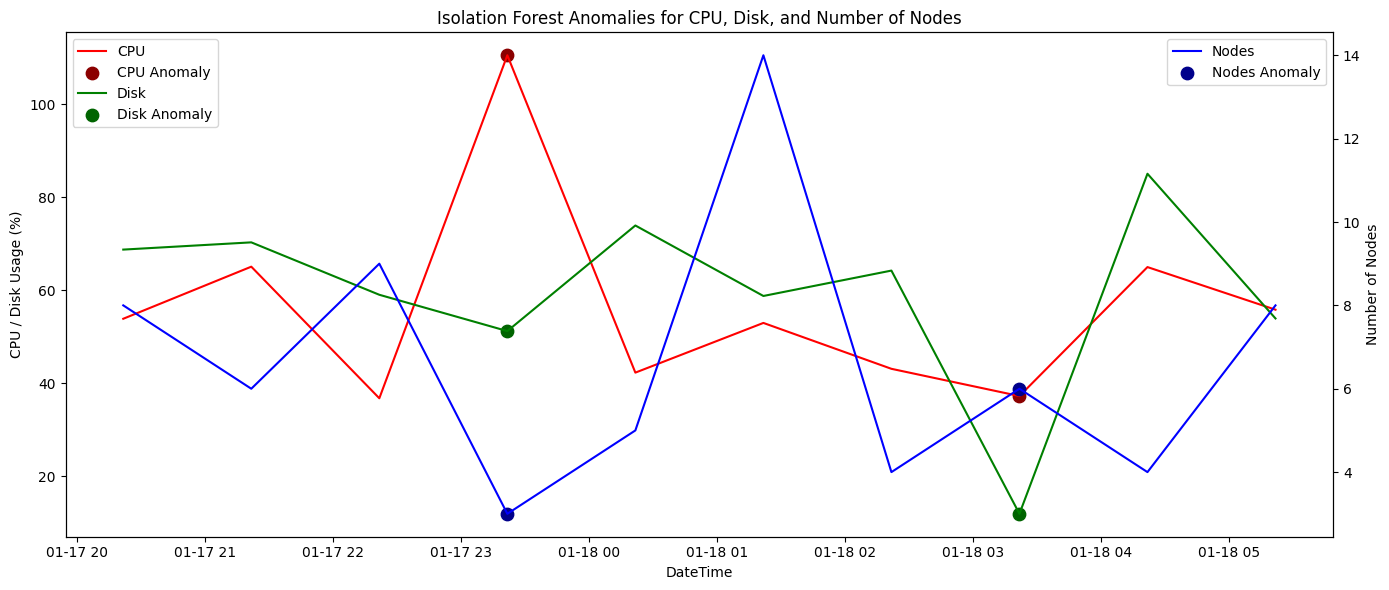

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# Optionally force anomalies for demonstration
df_test.loc[3, 'CPU_Usage'] += 30
df_test.loc[7, 'Disk_Usage'] -= 25
df_test.loc[5, 'Number_of_Nodes'] += 4

# Use Isolation Forest
iso = IsolationForest(contamination=0.2, random_state=42)
# Fit on all metrics together
df_test['anomaly'] = iso.fit_predict(df_test[['CPU_Usage', 'Disk_Usage', 'Number_of_Nodes']])
# Convert to boolean: -1 = anomaly, 1 = normal
df_test['anomaly'] = df_test['anomaly'] == -1

# Plot
fig, ax1 = plt.subplots(figsize=(14,6))

# CPU
sns.lineplot(data=df_test, x='DateTime', y='CPU_Usage', label='CPU', color='red', ax=ax1)
ax1.scatter(df_test['DateTime'][df_test['anomaly']],
            df_test['CPU_Usage'][df_test['anomaly']],
            color='darkred', s=80, label='CPU Anomaly')

# Disk
sns.lineplot(data=df_test, x='DateTime', y='Disk_Usage', label='Disk', color='green', ax=ax1)
ax1.scatter(df_test['DateTime'][df_test['anomaly']],
            df_test['Disk_Usage'][df_test['anomaly']],
            color='darkgreen', s=80, label='Disk Anomaly')

ax1.set_ylabel('CPU / Disk Usage (%)')
ax1.set_xlabel('DateTime')
ax1.legend(loc='upper left')

# Number of Nodes on secondary axis
ax2 = ax1.twinx()
sns.lineplot(data=df_test, x='DateTime', y='Number_of_Nodes', label='Nodes', color='blue', ax=ax2)
ax2.scatter(df_test['DateTime'][df_test['anomaly']],
            df_test['Number_of_Nodes'][df_test['anomaly']],
            color='darkblue', s=80, label='Nodes Anomaly')
ax2.set_ylabel('Number of Nodes')
ax2.legend(loc='upper right')

plt.xticks(rotation=45)
plt.title('Isolation Forest Anomalies for CPU, Disk, and Number of Nodes')
plt.tight_layout()
plt.show()


Alert

In [ ]:
import requests
import os

SLACK_WEBHOOK = os.environ.get("SLACK_WEBHOOK")
# --- Combine anomaly flags ---
df_test['anomaly'] = (
    df_test['anomaly_cpu'] |
    df_test['anomaly_disk'] |
    df_test['anomaly_nodes']
)

if df_test['anomaly'].any():

    anomalies = df_test[df_test['anomaly']]

    body = "⚠️ *EKS Metric Anomalies Detected*\n\n"

    for _, row in anomalies.iterrows():
        body += (
            f"🕒 {row['DateTime']}\n"
            f"• CPU: {row['CPU_Usage']:.2f}% {'🚨' if row['anomaly_cpu'] else ''}\n"
            f"• Disk: {row['Disk_Usage']:.2f}% {'🚨' if row['anomaly_disk'] else ''}\n"
            f"• Nodes: {row['Number_of_Nodes']} {'🚨' if row['anomaly_nodes'] else ''}\n\n"
        )

    requests.post(slack_webhook, json={"text": body})

else:
    body = "✅ *All clear*: No anomalies detected in CPU, Disk, or Node metrics."
    requests.post(slack_webhook, json={"text": body})
